# Protein Domain Finder

Run this notebook **top to bottom** after installing dependencies and ensuring you have all necessary data/scripts. Each section will output and visualize the results inn parallel with hose discussed in the final paper and presentation submissions.

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.image as mpimg

## Data Preparation (Download and Preprocessing)

In [2]:
!python scripts/download_selected_pdbs.py

  [1/94] 1vy4
Desired structure not found or download failed. '1vy4': HTTP Error 403: Forbidden
  [2/94] 1bjr
Structure exists: 'data/selected_structures/pdb1bjr.ent' 
  [3/94] 2j28
Structure exists: 'data/selected_structures/pdb2j28.ent' 
  [4/94] 1ns5
Structure exists: 'data/selected_structures/pdb1ns5.ent' 
  [5/94] 1fjg
Structure exists: 'data/selected_structures/pdb1fjg.ent' 
  [6/94] 2j28
Structure exists: 'data/selected_structures/pdb2j28.ent' 
  [7/94] 5gpn
Desired structure not found or download failed. '5gpn': HTTP Error 403: Forbidden
  [8/94] 1euh
Structure exists: 'data/selected_structures/pdb1euh.ent' 
  [9/94] 1b04
Structure exists: 'data/selected_structures/pdb1b04.ent' 
  [10/94] 1aon
Structure exists: 'data/selected_structures/pdb1aon.ent' 
  [11/94] 1aig
Structure exists: 'data/selected_structures/pdb1aig.ent' 
  [12/94] 9p0p
Structure exists: 'data/selected_structures/pdb9p0p.ent' 
  [13/94] 1cbg
Structure exists: 'data/selected_structures/pdb1cbg.ent' 
  [14/94] 1d

In [3]:
# Compute distance matrices for all PDB chains.
!python scripts/distance_matrix.py

Processing 94 proteins

[1/94] 1VY4_BP Missing PDB file
[2/94] 1BJR_E ✓ (279, 279)
[3/94] 2J28_D ✓ (209, 209)
[4/94] 1NS5_A ✓ (149, 149)
[5/94] 1FJG_J ✓ (98, 98)
[6/94] 2J28_Z ✓ (70, 70)
[7/94] 5GPN_a Missing PDB file
[8/94] 1EUH_A ✓ (474, 474)
[9/94] 1B04_A ✓ (310, 310)
[10/94] 1AON_A ✓ (524, 524)
[11/94] 1AIG_M ✓ (299, 299)
[12/94] 9P0P_A ✓ (305, 305)
[13/94] 1CBG_A ✓ (490, 490)
[14/94] 1DT6_A ✓ (449, 449)
[15/94] 1RF4_A ✓ (427, 427)
[16/94] 1VJU_A ✓ (287, 287)
[17/94] 1A05_A ✓ (357, 357)
[18/94] 1D2R_A ✓ (326, 326)
[19/94] 1B8F_A ✓ (506, 506)
[20/94] 1LVO_A ✓ (299, 299)
[21/94] 1WZU_A ✓ (271, 271)
[22/94] 1FJG_E ✓ (150, 150)
[23/94] 2FTC_N ✓ (96, 96)
[24/94] 4F67_A ✓ (258, 258)
[25/94] 3HUL_A ✓ (277, 277)
[26/94] 1B0A_A ✓ (287, 287)
[27/94] 2F1L_A ✓ (162, 162)
[28/94] 1KGQ_A ✓ (274, 274)
[29/94] 1Q7R_A ✓ (194, 194)
[30/94] 1A6A_B ✓ (187, 187)
[31/94] 1ARZ_A ✓ (270, 270)
[32/94] 1BA3_A ✓ (540, 540)
[33/94] 1EVK_A ✓ (401, 401)
[34/94] 1SXJ_B ✓ (316, 316)
[35/94] 1RQ0_A ✓ (319, 319)
[3

In [4]:
# Build k-NN residue-residue graphs.
!python scripts/graph_builder.py

Processing 6p5a_B_distmat
Saved graph with 118 nodes, 692 edges
Processing 1BMF_D_distmat
Saved graph with 467 nodes, 2677 edges
Processing 5mg3_D_distmat
Saved graph with 414 nodes, 2361 edges
Processing 1GXB_A_distmat
Saved graph with 339 nodes, 1925 edges
Processing 6kod_D_distmat
Saved graph with 441 nodes, 2529 edges
Processing 1ADJ_A_distmat
Saved graph with 420 nodes, 2414 edges
Processing 6vme_E_distmat
Saved graph with 102 nodes, 586 edges
Processing 6xja_P_distmat
Saved graph with 1286 nodes, 7323 edges
Processing 4IR1_F_distmat
Saved graph with 342 nodes, 1975 edges
Processing 1AIG_M_distmat
Saved graph with 299 nodes, 1691 edges
Processing 8xft_C_distmat
Saved graph with 173 nodes, 995 edges
Processing 1HSK_A_distmat
Saved graph with 303 nodes, 1739 edges
Processing 4fye_A_distmat
Saved graph with 725 nodes, 4097 edges
Processing 5msx_A_distmat
Saved graph with 439 nodes, 2530 edges
Processing 9dou_A_distmat
Saved graph with 924 nodes, 5258 edges
Processing 1EWQ_A_distmat
S

## Clustering

In [5]:
# Louvain clustering (unsupervised)
!python scripts/louvain_clustering.py

Louvain Clustering (unsupervised)
Processing 210 proteins
Resolution: 1.0

Clustering: 100%|█████████████████████████████| 210/210 [00:11<00:00, 17.62it/s]
Summary
Successful: 210/210
Failed: 0/210

Predicted domain counts:
  Mean: 10.68
  Median: 11
  Range: 3 - 18
  Std Dev: 2.44

Modularity:
  Mean: 0.739
  Median: 0.742
Exact matches: 0.0/89 (0.0%)
Mean Absolute Error: 8.03
Median Absolute Error: 8.00
Std Deviation: 1.98
Mean Relative Error: 418.76%

Comparison:
  True domain count (mean): 2.49
  Predicted domain count (mean): 10.53
  Over-prediction factor: 4.22x

Error distribution:
absolute_error
0        0
1-2      0
3-5      7
6-10    76
>10      6
Name: count, dtype: int64

Worst 5 predictions (highest error):
pdb_chain  n_true  n_predicted  absolute_error  n_residues
   7M68_A     2.0           16            14.0        1387
   1FFY_A     3.0           16            13.0         917
   4LGL_A     2.0           14            12.0         946
   1CBG_A     1.0           12    

In [6]:
# Run comprehensive method comparison (including spectral, two-stage, hierarchical, etc.)
!python scripts/compare_all_methods.py


Methods:
  1. Louvain (unsupervised)
  2. Spectral-Graph (supervised - oracle n_domains)
  3. Two-Stage-Spectral (unsupervised)

Dataset: 94 proteins

100%|███████████████████████████████████████████| 94/94 [00:40<00:00,  2.33it/s]

Louvain (unsupervised):
  Exact matches: 0/89 (0.0%)
  Mean Absolute Error: 17.02
  Mean predicted domains: 19.52

Spectral-Graph (supervised):
  Exact matches: 89/89 (100.0%)
  Mean Absolute Error: 0.00
  Mean predicted domains: 2.49

Two-Stage-Spectral (unsupervised):
  Exact matches: 33/89 (37.1%)
  Mean Absolute Error: 0.93
  Mean predicted domains: 2.33
Detailed results: data/results/method_comparison.csv
Summary table: data/results/method_summary.csv


In [7]:
# Run random & ablation controls
!python scripts/random_controls.py

Random Controls
Random controls: 100%|██████████████████████████| 94/94 [00:12<00:00,  7.36it/s]

Random-Oracle:
  Proteins: 89
  Exact matches: 89/89 (100.0%)
  Mean Absolute Error: 0.00
  Note: Oracle n_domains, random labels

Length-Oracle:
  Proteins: 89
  Exact matches: 89/89 (100.0%)
  Mean Absolute Error: 0.00
  Note: Oracle n_domains, equal-length splits

Predict-One:
  Proteins: 89
  Exact matches: 19/89 (21.3%)
  Mean Absolute Error: 1.49
  Note: No oracle knowledge

Predict-Mean:
  Proteins: 89
  Exact matches: 33/89 (37.1%)
  Mean Absolute Error: 0.92
  Note: No oracle knowledge
Ablations: 100%|████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]

                   error   n_edges  graph_density
method                                          
Threshold-10.0A   5.632  3657.579          0.061
Threshold-6.0A   12.421  1109.842          0.019
Threshold-8.0A    8.053  2020.579          0.035
kNN-k10           7.579  2299.895          0.042
kNN-k15           5.947  

## Hyperparameters

In [8]:
!python scripts/hyperparameter_optimization.py

Hyperparameter Optimization - TWO-STAGE SPECTRAL

Total dataset: 94 proteins
Training set: 30 proteins
Test set: 64 proteins

Training set domain distribution:
domain_bin
1      6
2     10
3      6
4+     8
Name: count, dtype: int64
Training Set Grid Search
Grid search: 240 combinations
Training set: 30 proteins

Grid search: 100%|████████████████████████████| 240/240 [51:17<00:00, 12.82s/it]
Top Ten Parameter Configurations
estimation_method  sigma_factor  max_domains  k_graph  mean_error  median_error  std_error  exact_match_rate  n_proteins
         eigengap           0.5           12        5         1.0           1.0   1.069045          0.428571          28
         eigengap           0.5           12       15         1.0           1.0   1.069045          0.428571          28
         eigengap           0.5            8       20         1.0           1.0   1.069045          0.428571          28
         eigengap           0.5           10       15         1.0           1.0   1.069

## Tables & Main Results

In [9]:
# Display the method comparison main results table
method_comp_df = pd.read_csv('data/results/method_comparison.csv')
method_comp_df.head()

,pdb_chain,method,success,error,n_predicted,n_true,exact_match,absolute_error,relative_error,supervised,n_residues,n_estimated
0,1VY4_BP,ALL,False,PDB file not found: data/selected_structures/p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1BJR_E,Louvain,True,NaN,19.0,1.0,0.0,18.0,18.0,False,279.0,NaN
2,1BJR_E,Spectral-Graph,True,NaN,1.0,1.0,1.0,0.0,0.0,True,279.0,NaN
3,1BJR_E,Two-Stage-Spectral,True,NaN,5.0,1.0,0.0,4.0,4.0,False,279.0,5.0
4,2J28_D,Louvain,True,NaN,15.0,1.0,0.0,14.0,14.0,False,209.0,NaN


In [10]:
summ = pd.read_csv('data/results/method_summary_table.csv')
display(summ)

,method,N,Exact_Matches,MAE,Avg_Predicted,Exact Match %
0,Louvain,89,0,17.022472,19.516854,0.0
1,Spectral-Distance,89,89,0.000000,2.494382,100.0


## Figures for Paper & Slides

In [15]:
# Generate all publication-ready figures and panels
!python scripts/create_figs.py

Figure 1: Comprehensive Method Comparison
Figure 2: Oracle Knowledge Analysis
Figure 3: Hyperparameter Optimization Heatmap
Figure 4: Performance by Domain Count

All figures saved to: data/results/figures/


Output Figure: fig1_comprehensive_comparison.png


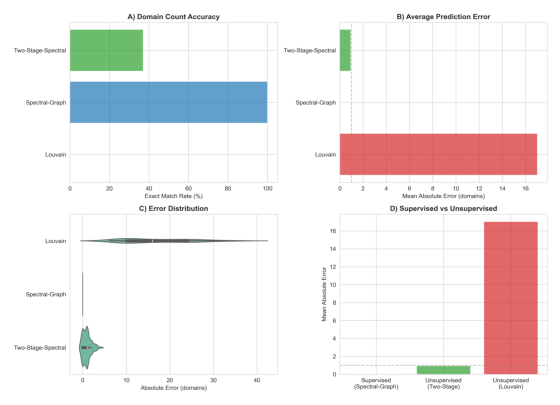

Output Figure: fig2_oracle_comparison.png


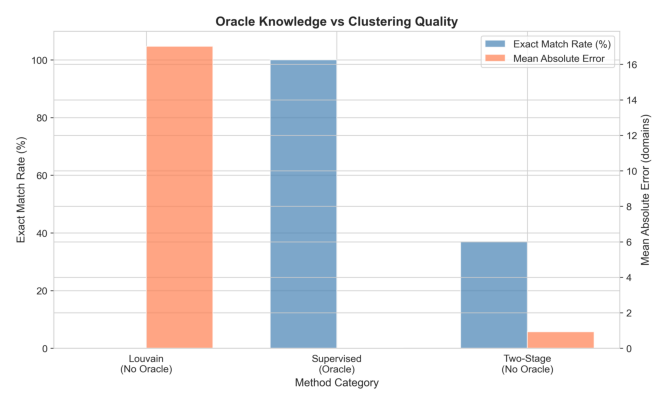

Output Figure: fig3_hyperparameter_heatmap.png


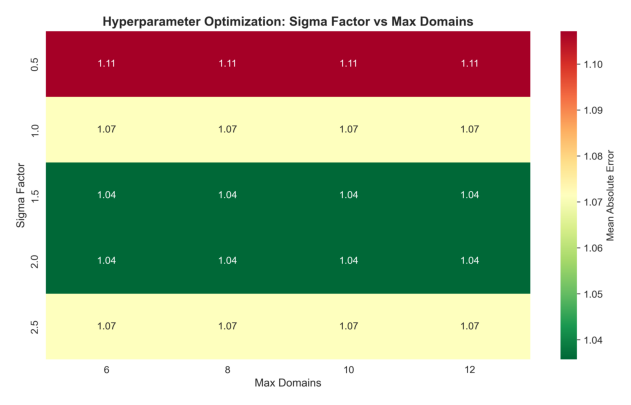

Output Figure: fig4_performance_by_complexity.png


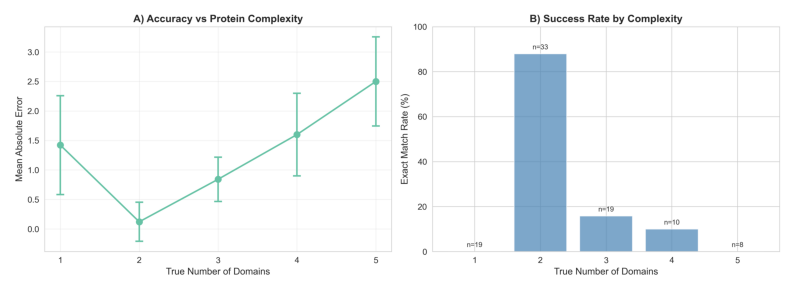

In [17]:
# Display every generated figure for the paper
fig_dir = Path('data/results/figures')
figs = sorted(glob.glob(str(fig_dir / '*.png'))) + sorted(glob.glob(str(fig_dir / '*.pdf')))
for fig in figs:
    print(f"Output Figure: {os.path.basename(fig)}")
    if fig.endswith('.png'):
        img = mpimg.imread(fig)
        plt.figure(figsize=(10,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"See file: {fig}")

## Visualize Domain Assignments (Per-protein Visualizations)

In [13]:
!python scripts/visualize_domains.py

Batch mode: visualizing 5 proteins
Saved: data/visualizations/1A05_A_comparison.png
Saved: data/visualizations/1A2O_A_comparison.png
Saved: data/visualizations/1A5Z_A_comparison.png
Saved: data/visualizations/1A6A_B_comparison.png
Saved: data/visualizations/1ACM_A_comparison.png

Visualized 5 proteins
Saved to: data/visualizations/


Domain Visualization: 1A05_A_comparison.png


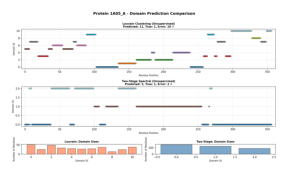

Domain Visualization: 1A2O_A_comparison.png


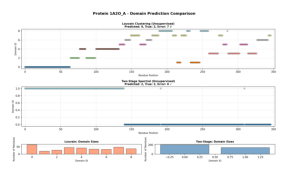

Domain Visualization: 1A5Z_A_comparison.png


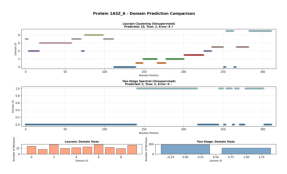

Domain Visualization: 1A6A_B_comparison.png


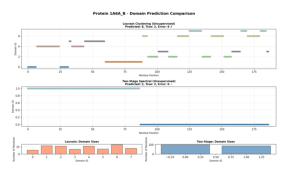

Domain Visualization: 1ACM_A_comparison.png


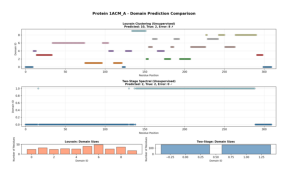

Domain Visualization: 1eg2_A_comparison.png


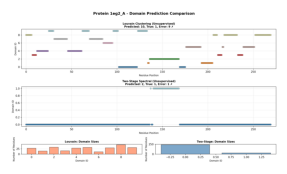

Domain Visualization: 1eg2_A_distmat_comparison.png


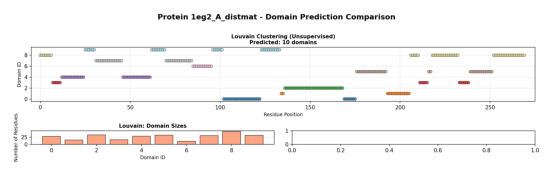

Domain Visualization: 1kyq_C_comparison.png


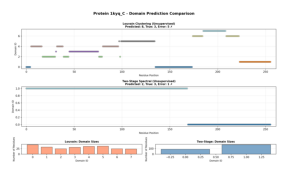

Domain Visualization: 1kyq_C_distmat_comparison.png


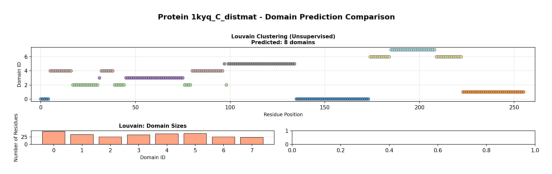

Domain Visualization: 1npy_A_distmat_comparison.png


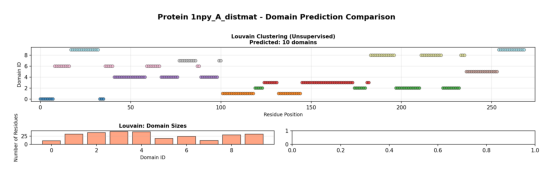

In [14]:
viz_dir = Path('data/visualizations')
viz_figs = sorted(glob.glob(str(viz_dir / '*.png')))
for fig in viz_figs:
    print(f"Domain Visualization: {os.path.basename(fig)}")
    img = mpimg.imread(fig)
    plt.figure(figsize=(10, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# END OF NOTEBOOK
---
